In [1]:
#!pip install rgf_python

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('bmh')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 30, 20

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
#from rgf.sklearn import RGFClassifier
import math
from scipy.stats import pearsonr, spearmanr, kendalltau, shapiro, pointbiserialr
from sklearn.linear_model import RandomizedLogisticRegression as RLR

C:\Users\nikit.patel.PRIYASOFT\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\nikit.patel.PRIYASOFT\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
train=pd.read_csv("train.csv")
train.columns

Index(['Months since Last Donation', 'Number of Donations',
       'Total Volume Donated (c.c.)', 'Months since First Donation',
       'Made Donation in March 2007'],
      dtype='object')

In [4]:
trains=train

In [5]:
df=trains

In [6]:
def createfeature(df):
    
    df['Average Donation per Month'] = (df['Total Volume Donated (c.c.)']/df['Months since First Donation'])
    df['Waiting Time'] = ((df['Months since First Donation'] - df['Months since Last Donation'])/df['Number of Donations'])
    df['Donated in the past 3-6 months'] = ((df['Months since Last Donation'] >= 3) &(df['Months since Last Donation'] <= 6))
    df['Frequent Donor'] = (df['Number of Donations'] >= 5)
    df['monthratio']=df['Months since Last Donation']/df['Months since First Donation']
    #df['monthratio']=df['Months since Last Donation']/df['Months since First Donation']
   
       
    df['Number of Donations sqrt']=np.sqrt(df['Number of Donations'].astype(float))
    df['Average Donation per Month sqrt']=np.sqrt(df['Average Donation per Month'])
    df['Months since First Donation sqrt']=np.sqrt(df['Months since First Donation'])
    df['Waiting Time sqrt']=np.sqrt(df['Waiting Time'])
    df['Months since Last Donation sqrt']=np.sqrt(df['Months since Last Donation'])

    df['Months since Last Donation mul']=df['Months since Last Donation']*df['Months since Last Donation']
    df['Number of Donations mul']=df['Number of Donations']*df['Number of Donations']
    df['Average Donation per Month mul']=df['Average Donation per Month']*df['Average Donation per Month']
    df['Waiting Time mul']=df['Waiting Time']*df['Waiting Time']
    df['Months since First Donation mul']=df['Months since First Donation']*df['Months since First Donation']
    
 

    means=df.mean(axis=1)

    df['mean']=means



    MAX=df.max(axis=1)

    df['max']=MAX


    MIN=df.min(axis=1)

    df['min']=MIN


    STD=df.std(axis=1)

    df['std']=STD


    MEDIAN=df.median(axis=1)

    df['median']=MEDIAN


    kurtosis=df.kurtosis(axis=1)

    df['kurtosis']=kurtosis


    skew=df.skew(axis=1)

    df['skew']=skew

    var=df.var(axis=1)

    df['var']=var

    return df

In [7]:
df=createfeature(df)
df.head(2)

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007,Average Donation per Month,Waiting Time,Donated in the past 3-6 months,Frequent Donor,monthratio,...,Waiting Time mul,Months since First Donation mul,mean,max,min,std,median,kurtosis,skew,var
0,2,50,12500,98,1,127.551020,1.920000,False,True,0.020408,...,3.686400,9604,2059.675245,16269.262807,0.0,5369.719571,8.485281,2.650102,2.041072,2.543052e+07
1,0,13,3250,28,1,116.071429,2.153846,False,True,0.000000,...,4.639053,784,893.128958,13472.576531,0.0,3872.275666,4.965278,7.923879,3.024420,1.314316e+07


In [8]:
df.isnull().sum()

Months since Last Donation          0
Number of Donations                 0
Total Volume Donated (c.c.)         0
Months since First Donation         0
Made Donation in March 2007         0
Average Donation per Month          0
Waiting Time                        0
Donated in the past 3-6 months      0
Frequent Donor                      0
monthratio                          0
Number of Donations sqrt            0
Average Donation per Month sqrt     0
Months since First Donation sqrt    0
Waiting Time sqrt                   0
Months since Last Donation sqrt     0
Months since Last Donation mul      0
Number of Donations mul             0
Average Donation per Month mul      0
Waiting Time mul                    0
Months since First Donation mul     0
mean                                0
max                                 0
min                                 0
std                                 0
median                              0
kurtosis                            0
skew        

In [9]:
features = df.drop(["Made Donation in March 2007","Total Volume Donated (c.c.)",'Frequent Donor', 'Donated in the past 3-6 months'], axis=1).columns


contdf=df[features]



In [10]:
df.columns

Index(['Months since Last Donation', 'Number of Donations',
       'Total Volume Donated (c.c.)', 'Months since First Donation',
       'Made Donation in March 2007', 'Average Donation per Month',
       'Waiting Time', 'Donated in the past 3-6 months', 'Frequent Donor',
       'monthratio', 'Number of Donations sqrt',
       'Average Donation per Month sqrt', 'Months since First Donation sqrt',
       'Waiting Time sqrt', 'Months since Last Donation sqrt',
       'Months since Last Donation mul', 'Number of Donations mul',
       'Average Donation per Month mul', 'Waiting Time mul',
       'Months since First Donation mul', 'mean', 'max', 'min', 'std',
       'median', 'kurtosis', 'skew', 'var'],
      dtype='object')

In [11]:
from sklearn.preprocessing import StandardScaler
#pd.options.mode.use_inf_as_na=True # treat inf as null


logdf=df[contdf.columns].apply(np.log)
dfff=logdf.fillna(0)
dfff = dfff.replace([np.inf, -np.inf,np.nan], 0)

scaler = StandardScaler()
dff = pd.DataFrame(scaler.fit_transform(dfff[contdf.columns]))
dff.columns=dfff[contdf.columns].columns

dff["Donation2007"]=df['Made Donation in March 2007'].values


In [12]:
dff

,Months since Last Donation,Number of Donations,Months since First Donation,Average Donation per Month,Waiting Time,monthratio,Number of Donations sqrt,Average Donation per Month sqrt,Months since First Donation sqrt,Waiting Time sqrt,...,Months since First Donation mul,mean,max,min,std,median,kurtosis,skew,var,Donation2007
0,-1.233234,2.925677,1.441204,1.628044,-0.540405,-2.298805,2.925677,1.628044,1.441204,-0.540405,...,1.441204,2.433797,1.605505,0.234682,1.748698,0.705298,-0.619936,-0.908996,1.752156,1
1,-1.972346,1.421642,0.160172,1.501249,-0.411762,1.163988,1.421642,1.501249,0.160172,-0.411762,...,0.160172,1.452241,1.435439,0.234682,1.438233,-0.231408,0.800413,0.957206,1.438404,1
2,-1.972346,1.653476,0.388351,1.480405,-0.426854,-1.999424,1.653476,1.480405,0.388351,-0.426854,...,0.388351,1.508649,1.407481,0.234682,1.413365,-0.145347,0.728884,0.823941,1.413768,1
3,-1.233234,1.902620,0.645336,1.442531,-0.413763,-1.606299,1.902620,1.442531,0.645336,-0.413763,...,0.645336,1.584202,1.356682,0.234682,1.371791,-0.000843,0.575131,0.559142,1.372619,1
4,-1.972346,2.106186,1.194600,0.965498,0.019650,-2.700964,2.106186,0.965498,1.194600,0.019650,...,1.194600,1.512155,0.716849,0.234682,0.946690,0.769189,-1.291515,-1.322274,0.949338,0
5,-0.494122,0.105651,-1.829649,2.532771,-1.270563,1.163988,0.105651,2.532771,-1.829649,-1.270563,...,-1.829649,2.948323,2.818995,0.234682,2.895117,-0.609289,0.901285,1.170346,2.896367,0
6,-1.233234,0.730473,-0.548617,1.600883,-0.667255,-0.567408,0.730473,1.600883,-0.548617,-0.667255,...,-0.548617,1.448058,1.569075,0.234682,1.576079,-0.666669,0.883682,1.127503,1.576020,1
7,-1.972346,1.332273,0.388351,1.093636,-0.104847,-1.999424,1.332273,1.093636,0.388351,-0.104847,...,0.388351,0.973516,0.888717,0.234682,0.879753,0.361913,0.569155,0.550351,0.879963,0
8,-0.256181,2.832580,1.441204,1.515943,-0.482611,-1.483524,2.832580,1.515943,1.441204,-0.482611,...,1.441204,2.317855,1.455147,-5.663531,1.625890,1.055265,-0.909795,-1.124804,1.629399,1
9,-1.972346,-0.215552,-1.829649,2.146002,-0.948556,1.163988,-0.215552,2.146002,-1.829649,-0.948556,...,-1.829649,2.280292,2.300231,0.234682,2.348459,-1.920846,0.901235,1.169990,2.349101,0


In [13]:
from sklearn.preprocessing import LabelEncoder
factorVar = ['Frequent Donor', 'Donated in the past 3-6 months']

le = LabelEncoder()

for i in factorVar:
    dff[i] = le.fit_transform(df[i])
 



df_train, df_val = train_test_split(dff, test_size=0.10,random_state=42)


In [14]:
# correlation=dff.corr(method='spearman')
# columns=abs(correlation).Donation2007.drop('Donation2007').sort_values()

# plt.figure(figsize=(25,40))
# plt.title("Spearman's correlation")
# sns.heatmap(abs(dff.drop('Donation2007', axis=1).corr(method='spearman')), cmap='Blues', annot=True, cbar=False)

In [15]:
correlation=dff.corr()
columns=abs(correlation).Donation2007.drop('Donation2007').sort_values()


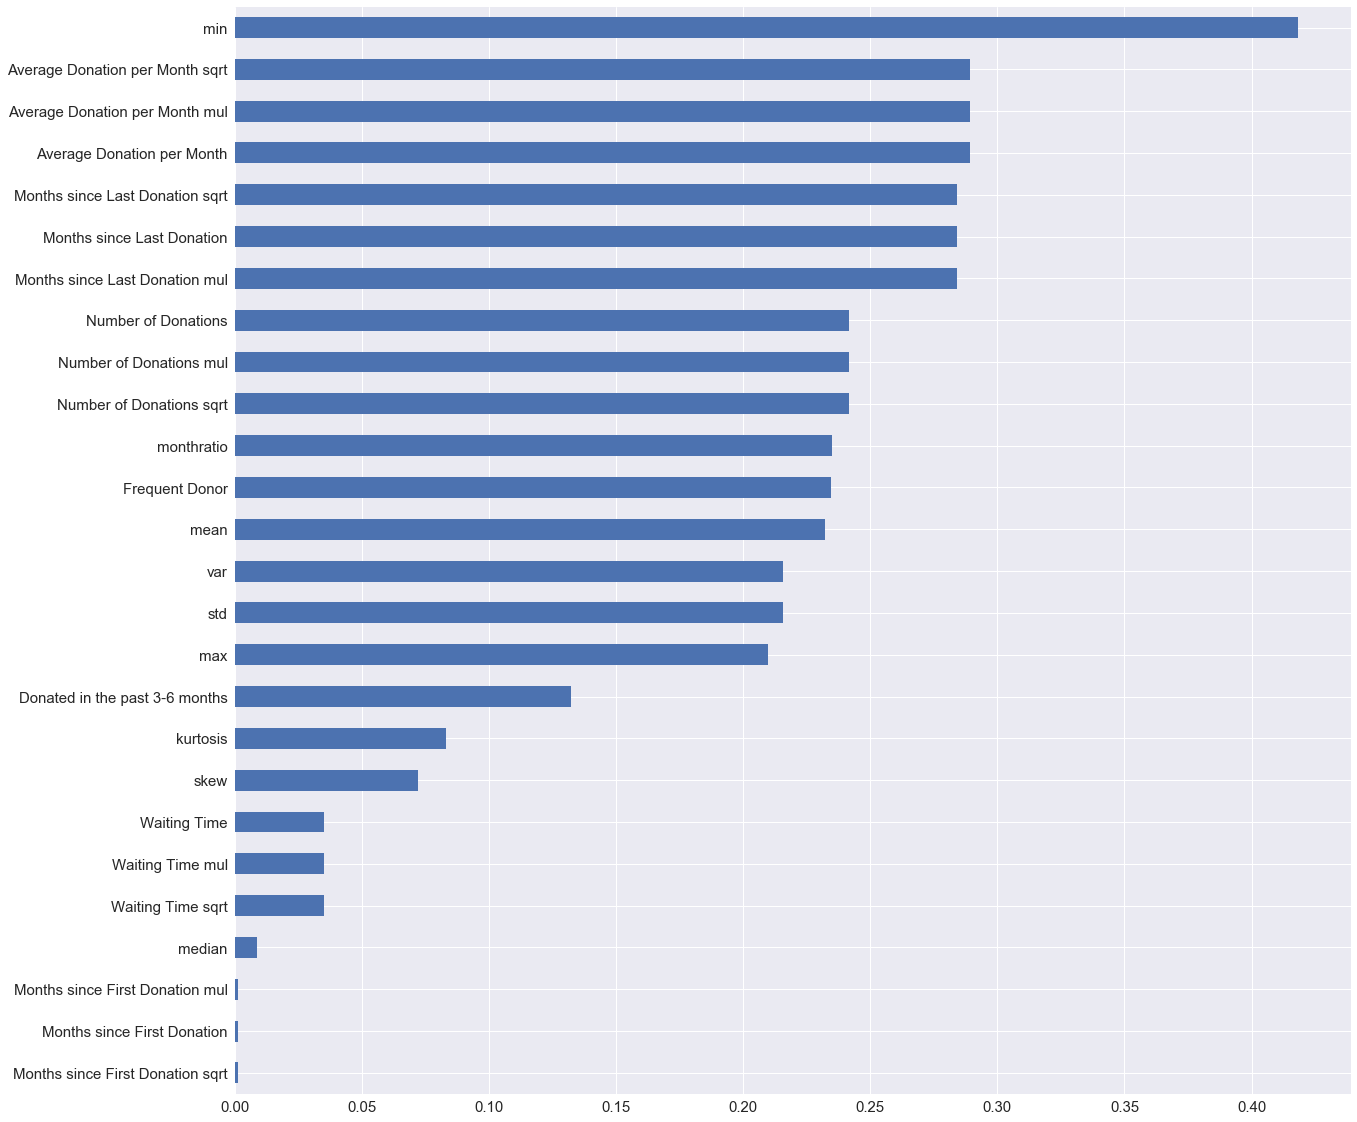

In [16]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(20,20))
(abs(correlation)
 .Donation2007
 .drop('Donation2007')
 .sort_values()
 .plot
 .barh())

In [17]:
from sklearn.linear_model import LogisticRegressionCV
Classifier = [
  
        LGBMClassifier(
            
        n_estimators=132,#132
        learning_rate=0.1,
        num_leaves=64,
        max_depth=7,
        min_data_in_leaf=40,
        max_bin =15,
        reg_alpha=0.8, reg_lambda=0.6,
        colsample_bytree=1.0,
        min_split_gain=0.001, objective = "binary",random_state=42,
        stratified=True
                
        )
    
   
  
   
    ]

In [18]:
limit=17

In [19]:
Accuracy=[]
Model=[]

# for classifier in Classifier:
#     try:
        
#         fit = classifier.fit(df_train[columns.tail(limit).index], df_train["Donation2007"])
#         pred = fit.predict_proba(df_val[columns.tail(limit).index])
#     except Exception:
#         fit = classifier.fit(df_train[columns.tail(limit).index], df_train["Donation2007"])
#         pred = fit.predict_proba(df_val[columns.tail(limit).index])
        
        
#     score = classifier.score(df_val[columns.tail(limit).index], df_val["Donation2007"])
#     Model.append(classifier.__class__.__name__)
#     print('Accuracy of '+classifier.__class__.__name__+' is '+str(score))
    
#     print("************************************************************")
#     val_actual=np.array(df_val["Donation2007"])
#     val_pred=np.array(pred)
    
    
for classifier in Classifier:
    try:
        
        fit = classifier.fit(df_train[features], df_train["Donation2007"])
        pred = fit.predict_proba(df_val[features])
    except Exception:
        fit = classifier.fit(df_train[features], df_train["Donation2007"])
        pred = fit.predict_proba(df_val[features])
        
        
    score = classifier.score(df_val[features], df_val["Donation2007"])
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(score))
    
    print("************************************************************")
    val_actual=np.array(df_val["Donation2007"])
    val_pred=np.array(pred)

Accuracy of LGBMClassifier is 0.896551724138
************************************************************


In [20]:
### save model
lgbm = LGBMClassifier(
            
        n_estimators=132,#132
        learning_rate=0.1,
        num_leaves=64,
        max_depth=7,
        min_data_in_leaf=40,
        max_bin =15,
        reg_alpha=0.8, reg_lambda=0.6,
        colsample_bytree=1.0,
        min_split_gain=0.001, objective = "binary",random_state=42,
        stratified=True
                
        )
    
fit = lgbm.fit(df_train[features], df_train["Donation2007"])
pickle.dump(fit,open( "blood_mode.pickle", "wb" ) )



In [21]:
logloss=log_loss(val_actual,val_pred[:,1])

In [22]:
logloss

0.29384283379002119

In [23]:
test=pd.read_csv("test.csv")

In [24]:
test=createfeature(test)

In [25]:
df_train[features].columns

Index(['Months since Last Donation', 'Number of Donations',
       'Months since First Donation', 'Average Donation per Month',
       'Waiting Time', 'monthratio', 'Number of Donations sqrt',
       'Average Donation per Month sqrt', 'Months since First Donation sqrt',
       'Waiting Time sqrt', 'Months since Last Donation sqrt',
       'Months since Last Donation mul', 'Number of Donations mul',
       'Average Donation per Month mul', 'Waiting Time mul',
       'Months since First Donation mul', 'mean', 'max', 'min', 'std',
       'median', 'kurtosis', 'skew', 'var'],
      dtype='object')

In [26]:
from sklearn.preprocessing import StandardScaler


testlogdf=test[contdf.columns].apply(np.log)
#testtt=testlogdf.fillna(0)
testtt = testlogdf.replace([np.inf, -np.inf,np.nan], 0)


scaler = StandardScaler()

testt = pd.DataFrame(scaler.fit_transform(testtt[contdf.columns]))
testt.columns=testtt[contdf.columns].columns



factorVar = ['Frequent Donor', 'Donated in the past 3-6 months']

#le = LabelEncoder()

for i in factorVar:
    le = LabelEncoder()
    testt[i] = le.fit_transform(test[i])
    print (le.classes_)
    

[False  True]
[False  True]


In [27]:
df_train[features].shape

(518, 24)

In [28]:
y_pred = fit.predict(testt[features])